In [ ]:
# hepatocellular-carcinoma-data.ipynb
#
# Bryan Daniels
# 2023/3/29
#
# Apply our technique to liver cancer dataset (GEO GSE6764)
#

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from landauAnalysis import principalComponents
import landauAnalysis

In [2]:
from toolbox import setDefaultParams,makePretty,load
setDefaultParams()

In [5]:
%load_ext autoreload
%autoreload 2

In [41]:
# 2023.3.30 taken from BoolODE_data.ipynb
from landau.landauAnalysis import LandauTransitionDistributionRelativeLogPDF
def bistablePlot(finalStates,vec,Jvals,Jvecs,c,d,nuMu,returnData=False,plotTheory=True,plotGaussian=True,
                 separateByGroup=False,bins=30,**histKwargs):
    
    # calculate projection along eigenvector
    
    if (len(vec) == 1) and (finalStates.shape[1] > 1):
        # compute principal eigenvector manually if we're given a vec from a projected analysis
        PCAvals,PCAvecs = principalComponents(finalStates,k=1)
        projVec = PCAvecs[0]
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = np.mean(x)
    else:
        projVec = vec
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = sampleMean
    
    
    # plot histogram of data
    if separateByGroup: # finalStates must be indexed by group for this to work
        colors = ['C0','C2']
        x_indexed = pd.Series(x,index=finalStates.index)
        bin_edges = np.histogram_bin_edges(x_indexed,bins=bins)
        for group,color in zip(x_indexed.index.unique(),colors):
            plt.hist(x_indexed.loc[group],density=True,bins=bin_edges,label=group,color=color,**histKwargs)
    else:
        plt.hist(x,density=True,bins=bins,**histKwargs)

    if plotTheory:
        # plot inferred relative log-likelihood
        xRange = 1.5*(x.max() - x.min())
        plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,xRange=xRange)
        
    if plotGaussian:
        # compare to Gaussian null model
        xVals = np.linspace(-xRange/2.,xRange/2.,500)
        distGaussian = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                            meanFinalState + xVal*vec,   
                            meanFinalState,
                            Jvals,
                            Jvecs,
                            vec,
                            1.,
                            0.)) for xVal in xVals ]
        distGaussian = distGaussian / (np.sum(distGaussian)*(np.diff(xVals)[0]))
        plt.plot(xVals,distGaussian,lw=2,color='black',label='Gaussian mixture fit')

    plt.xlabel('Gene expression\nalong bistable dimension')
    plt.ylabel('Probability')

    if returnData:
        return {'x': x,
                'vec': vec,
                'mu': mu,
                'runIndex': runIndex,
                'meanFinalState': meanFinalState,
                }
    
def plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,color='crimson',lw=5,zorder=10,xRange=20):
    """
    (x = 0 corresponds to the mean value along the projected axis)
    """
    xVals = np.linspace(-xRange/2.,xRange/2.,500)

    dist = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                        xVal*vec,   
                        nuMu*vec,
                        Jvals,
                        Jvecs,
                        vec,
                        c,
                        d)) for xVal in xVals ]
    dist = dist / (np.sum(dist)*(np.diff(xVals)[0]))
    plt.plot(xVals,dist,lw=lw,color=color,zorder=zorder,label='Landau fit')

In [54]:
expr = pd.read_csv('../Data/230329/GSE6764.csv',index_col=0).T
groups = pd.read_csv('../Data/230329/GSE6764_groups.csv')['x']
gene_symbols = pd.read_csv('../Data/230329/GSE6764_gene_symbols.csv')['x']
gene_functions = pd.read_csv('../Data/230329/GSE6764_gene_GO_functions.csv')['x']

# create gene info dataframe indexed by ID
genedf = pd.DataFrame(np.array([gene_symbols,gene_functions]).T,
                      columns=['gene symbol','GO function'],
                      index=expr.columns)

# create expression dataframe indexed by group
groups.index = expr.index
expr['group'] = groups
expr_by_group = expr.set_index('group')

In [9]:
# check that group memberships line up correctly
assert(expr.group['GSM155919']=='control')
assert(expr.group['GSM155945']=='early.HCC')
assert(expr.group['GSM155993']=='very.early.HCC')

In [10]:
groups.unique()

array(['control', 'cirrhosis', 'low.grade.dysplastic',
       'high.grade.dysplastic', 'very.early.HCC', 'very.advanced.HCC',
       'early.HCC', 'advanced.HCC'], dtype=object)

In [58]:
for group in groups.unique():
    print("{} samples from group {}".format(len(groups[groups==group]),group))

10 samples from group control
10 samples from group cirrhosis
10 samples from group low.grade.dysplastic
7 samples from group high.grade.dysplastic
8 samples from group very.early.HCC
10 samples from group very.advanced.HCC
10 samples from group early.HCC
7 samples from group advanced.HCC


In [11]:
groups_to_include = ['control','early.HCC']
expr_by_group.loc[groups_to_include]

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
group,,,,,,,,,,,,,,,,,,,,,
control,6.747320,6.983427,5.891035,6.526272,2.419032,7.259997,4.022643,3.448663,7.121896,14.562678,...,12.692589,12.640021,14.446999,14.428785,8.759439,7.768482,8.181942,2.930802,2.712316,2.946736
control,6.904966,6.930655,5.577698,6.829482,2.364791,6.933183,4.382799,3.856010,5.793573,14.117659,...,12.174386,12.018106,14.221058,14.217079,8.561448,7.452249,7.996106,2.855103,2.668264,2.791818
control,6.472824,7.009717,5.915519,6.907095,2.400172,6.809247,3.940101,3.742125,5.211600,14.521079,...,12.339897,12.131873,14.343935,14.318451,8.672302,7.357438,7.986832,3.061501,2.652897,2.855386
control,6.495295,7.088534,5.859316,6.538420,2.356828,7.275985,3.847656,3.385044,6.012645,14.558176,...,12.329202,12.049937,14.276815,14.226841,8.984051,7.995496,8.345121,2.887112,2.826150,2.790144
control,6.093801,7.244202,5.931187,6.371266,2.290088,6.875350,3.622345,3.373676,6.973967,13.973258,...,12.340295,12.178120,14.236523,14.130023,9.016234,7.831390,8.566827,2.657743,2.523845,2.610702
control,6.757410,6.953614,5.695732,6.395807,2.315995,7.224947,3.825419,3.982948,6.082275,14.655844,...,12.364419,12.234614,14.264061,14.189601,9.103985,8.028619,8.665325,2.736620,2.580633,2.771184
control,5.665364,7.529126,5.442499,6.424200,2.325611,6.409362,3.753455,3.297325,4.594555,14.339091,...,12.128349,12.064622,14.222153,14.283993,8.236694,7.312638,8.018089,2.740412,2.604313,2.711142
control,6.222606,6.482413,5.569664,6.682545,2.354049,6.847195,3.818401,3.358720,6.702159,14.507516,...,12.123342,12.076428,14.314378,14.200508,8.237038,7.169885,7.769230,2.826492,2.648378,2.745405
control,6.479856,7.612249,6.752454,6.675110,2.331444,7.035239,3.775325,3.413621,5.051407,14.274880,...,12.694889,12.534050,14.444323,14.173662,7.995490,7.216688,7.769977,2.737261,2.599632,2.662716


In [17]:
# load results from runs on the agave cluster using hepatocellular-carcinoma-data.py
skip_factor = 1
resultsDict = load('230331_HCC_resultsDict_skip{}.pkl'.format(skip_factor))
groups_to_include_list = list(resultsDict.keys())

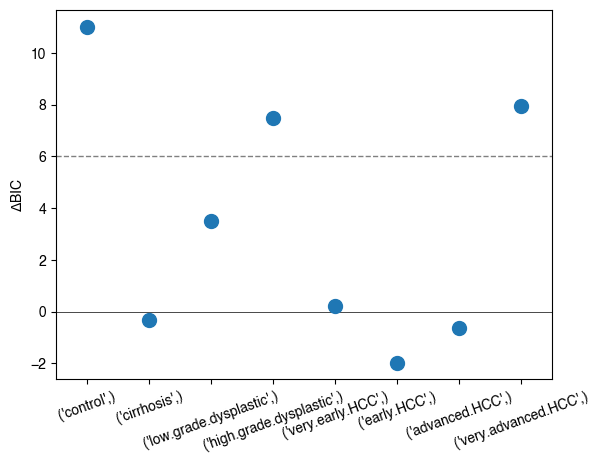

In [18]:
plt.plot([-resultsDict[groups]['bicDiff'] for groups in groups_to_include_list[:8]],'o',ms=10)
xmin,xmax = -0.5,7.5
plt.hlines([0,],xmin=xmin,xmax=xmax,color='k',lw=0.5,zorder=-10)
plt.hlines([6,],xmin=xmin,xmax=xmax,color='gray',lw=1,ls='--',zorder=-10)
plt.axis(xmin=xmin,xmax=xmax)
plt.ylabel('$\Delta$BIC')
plt.xticks(ticks=range(8),labels=groups_to_include_list[:8],rotation=20);
plt.savefig('230407_DeltaBIC_vs_time_individual_groups_HCC_skip{}.pdf'.format(skip_factor))

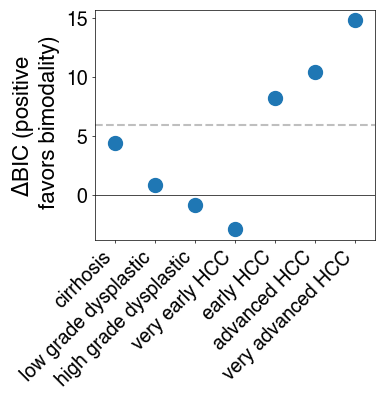

In [39]:
plt.figure(figsize=(4,4))
plt.plot([-resultsDict[groups]['bicDiff'] for groups in groups_to_include_list[8:]],'o',ms=10)
xmin,xmax = -0.5,6.5
plt.hlines(0,xmin,xmax,'k',lw=0.5)
plt.hlines(6,xmin,xmax,'0.75',ls='--',lw=1.5,zorder=-10)
plt.axis(xmin=xmin,xmax=xmax)
plt.ylabel('$\Delta$BIC (positive \n favors bimodality)')
labels = [ group[1].replace('.',' ') for group in groups_to_include_list[8:] ]
plt.xticks(ticks=range(7),labels=labels,rotation=45,ha='right')
makePretty()
plt.subplots_adjust(bottom=0.375,top=0.95,left=0.25,right=0.95)
plt.savefig('230407_DeltaBIC_vs_time_control_paired_groups_HCC_skip{}.pdf'.format(skip_factor))

In [43]:
landauData

{'mu': -1.8207657603852567e-14,
 'valList': array([0.00014274]),
 'vecList': [array([1.])],
 'llList': array([-8.9119719]),
 'cList': array([-6.77127901]),
 'dList': array([5.73138001]),
 'nuMuList': array([-6.87441496]),
 'bicDiffList': array([-14.82821153])}

In [48]:
reduced_expr

,0
group,
control,88.301122
control,96.235219
control,98.694530
control,101.650329
control,71.395216
control,85.975371
control,43.693276
control,98.600128
control,43.086095


early.HCC
Number of datapoints = 20
c = -4.146006155104734, d = 3.4284635998558386, nuMu = -4.161310150472927
vals = 0.0002787976803662886
vecs = [1.]
mu = 5.240252676230739e-14

advanced.HCC
Number of datapoints = 17
c = -6.0086274271638995, d = 4.68636640429777, nuMu = -20.865903873712483
vals = 0.0002044063176119739
vecs = [1.]
mu = -1.1834977442504169e-13

very.advanced.HCC
Number of datapoints = 20
c = -6.771279013425548, d = 5.731380005674793, nuMu = -6.87441496045189
vals = 0.0001427442190429949
vecs = [1.]
mu = -1.8207657603852567e-14



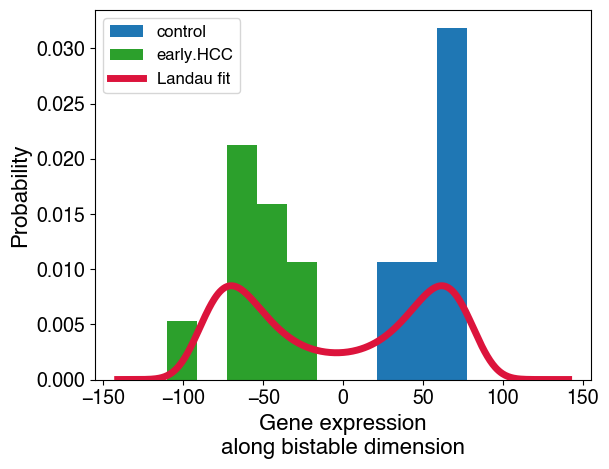

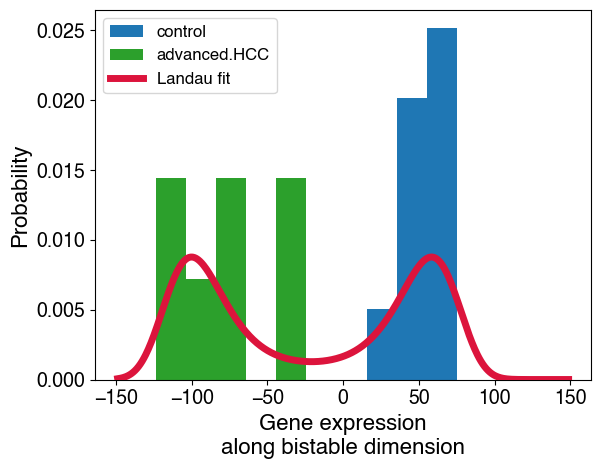

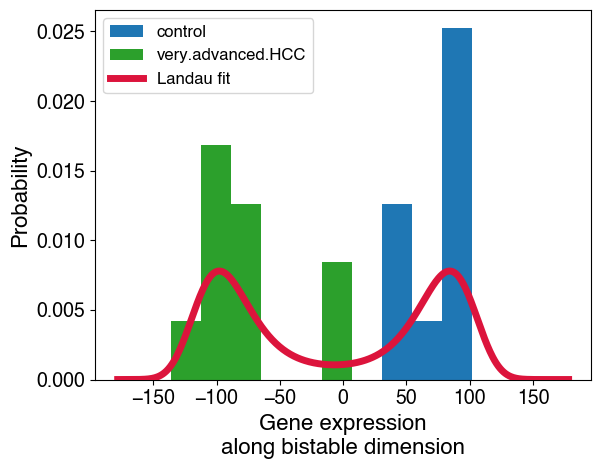

In [52]:
# output data to make histogram plots in Mathematica

makePlots = True
for groups in groups_to_include_list:
    reduced_expr = resultsDict[groups]['reduced_expr']
    landauData = resultsDict[groups]['landauData']
    if len(groups) > 1 and landauData['bicDiffList'][0] < -6:
        Jvals = landauData['valList']
        Jvecs = landauData['vecList']
        c = landauData['cList'][0]
        d = landauData['dList'][0]
        nuMu = landauData['nuMuList'][0]

        print(groups[1])
        print("Number of datapoints = {}".format(len(reduced_expr)))
        print("c = {}, d = {}, nuMu = {}".format(c,d,nuMu))
        print("vals = {}".format(Jvals[0]))
        print("vecs = {}".format(Jvecs[0]))
        print("mu = {}".format(landauData['mu']))
        print()
        
        reduced_expr.to_csv('230407_HCC_reduced_data_{}.csv'.format(groups[1]))
        if makePlots:
            plt.figure()
            bistablePlot(reduced_expr,Jvecs[0],Jvals,Jvecs,c,d,nuMu,plotGaussian=False,separateByGroup=True,bins=10)
            plt.legend();

In [300]:
# print genes with largest s 
for groups in groups_to_include_list:
    s = resultsDict[groups]['s']
    sdf = pd.concat([s,genedf],axis=1)
    bicDiff = resultsDict[groups]['bicDiff']
    if len(groups) > 1 and bicDiff < -6:
        print(groups,bicDiff)
        print(sdf.sort_values(by='s',ascending=False)[['s','gene symbol']][:15])
        print()

('control', 'early.HCC') -8.258203653189035
                     s                        gene symbol
1555758_a_at  0.923174                              CDKN3
214584_x_at   0.893597                              ACACB
206364_at     0.892508                              KIF14
228191_at     0.879232                             FLVCR1
230478_at     0.877138                               OIT3
209714_s_at   0.873160                              CDKN3
225834_at     0.868633  FAM72A///FAM72D///FAM72B///FAM72C
222906_at     0.865450                             FLVCR1
202813_at     0.865102                             TARBP1
204428_s_at   0.863786                               LCAT
225927_at     0.863682                             MAP3K1
223967_at     0.862597                            ANGPTL6
205911_at     0.855225                              PTH1R
1559065_a_at  0.855176                             CLEC4G
207621_s_at   0.852256                               PEMT

('control', 'advanced.HCC')